## VGG16

**Load LFW Dataset**

In [1]:
import numpy as np

np.random.seed(42)

from sklearn.datasets import fetch_lfw_pairs
lfw_pairs_train = fetch_lfw_pairs(subset='train', resize=1.4, color = True, slice_ = (slice(45, 205, None), slice(45, 205, None)))
lfw_pairs_test = fetch_lfw_pairs(subset='test', resize=1.4, color = True, slice_ = (slice(45, 205, None), slice(45, 205, None)))
# lfw_pairs_val = fetch_lfw_pairs(subset='10_folds', resize=1.4, color = True, slice_ = (slice(45, 205, None), slice(45, 205, None)))

**Sample plot**

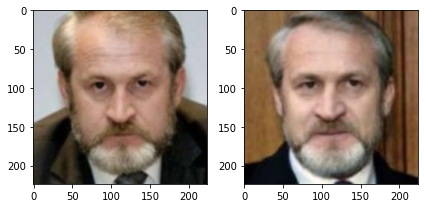

In [2]:
import matplotlib.pyplot as plt
lfw_pairs_train.pairs[0].shape
idx = 20
plt.figure()
plt.subplot(1,2,1)
plt.imshow(lfw_pairs_train.pairs[idx,0].astype('uint8'))
plt.subplot(1,2,2)
plt.imshow(lfw_pairs_train.pairs[idx,1].astype('uint8'))
plt.tight_layout()
plt.show()

## VGG16 feature Extractor

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K


IMG_SHAPE = (224, 224, 3)

#create siamese network
def tf_siamese_nn(shape, fineTune=False):
    inputs = keras.layers.Input(shape)
    # preprocess_fn = keras.applications.vgg16.preprocess_input
    
    base_model = keras.applications.vgg16.VGG16(input_shape=shape, include_top=True, weights='/content/drive/MyDrive/DL_HW4/vgg16_weights_tf_dim_ordering_tf_kernels.h5')
    # base_model = keras.applications.vgg16.VGG16(input_shape=shape, include_top=True, weights='imagenet')
    
    if fineTune==False:
        base_model.trainable=False
    else:
        base_model.trainable = True
        # Fine-tune from this layer onwards
        fine_tune_at = len(base_model.layers) - int(len(base_model.layers)*.10)
        print(fine_tune_at)
        # Freeze all the layers before the `fine_tune_at` layer
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable =  False
    model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)
    
    return model

#distance metric
def euclidean_distance(vectors):
    # unpack the vectors into separate lists
    (featsA, featsB) = vectors
    # compute the sum of squared distances between the vectors
    sumSquared = K.sum(K.square(featsA - featsB), axis=1,keepdims=True)
    # return the euclidean distance between the vectors
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))

In [4]:
#create verification model using siamese network;
img1 = keras.layers.Input(shape=IMG_SHAPE)
img2 =  keras.layers.Input( shape=IMG_SHAPE)
featureExtractor = tf_siamese_nn(IMG_SHAPE)
featsA = featureExtractor(img1)
featsB = featureExtractor(img2)
# finally, construct the siamese network
distance = keras.layers.Lambda(euclidean_distance)([featsA, featsB])
outputs = keras.layers.Dense(1, activation="softmax")(distance)
model_nft = keras.Model(inputs=[img1, img2], outputs=outputs)
model_nft.summary()

model_nft.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 4096)         134260544   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[0][0]                

**Inference - Without fine tuning**

In [5]:
test_pairA = lfw_pairs_test.pairs[:,0].reshape(lfw_pairs_test.target.shape[0],224,224,3)
test_pairB = lfw_pairs_test.pairs[:,1].reshape(lfw_pairs_test.target.shape[0],224,224,3)

preds = model_nft.predict( [test_pairA , test_pairB])
print(preds[0:10])
print(lfw_pairs_test.target[0:10])

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
[1 1 1 1 1 1 1 1 1 1]


______________Positive Pairs :Same_______________


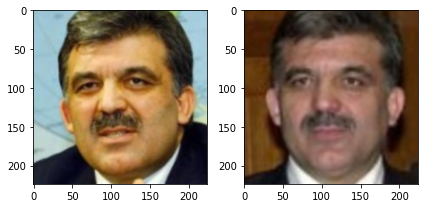

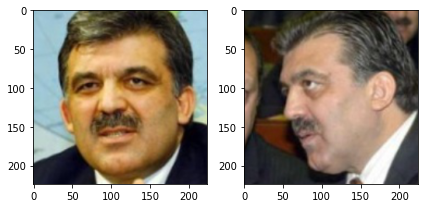

______________Negative Pairs :Different_______________


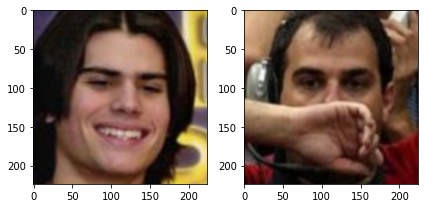

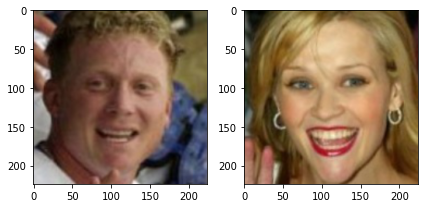

In [6]:
import numpy as np

idx_0 = np.where(lfw_pairs_test.target==0)[0]
idx_1 = np.where(lfw_pairs_test.target==1)[0]

print('______________Positive Pairs :Same_______________')
for i in range(2):
  plt.figure()
  plt.subplot(1,2,1)
  plt.imshow(lfw_pairs_test.pairs[idx_1[i],0].astype('uint8'))
  plt.subplot(1,2,2)
  plt.imshow(lfw_pairs_test.pairs[idx_1[i],1].astype('uint8'))
  plt.tight_layout()
  plt.show()

print('______________Negative Pairs :Different_______________')
for i in range(2):
  plt.figure()
  plt.subplot(1,2,1)
  plt.imshow(lfw_pairs_test.pairs[idx_0[i],0].astype('uint8'))
  plt.subplot(1,2,2)
  plt.imshow(lfw_pairs_test.pairs[idx_0[i],1].astype('uint8'))
  plt.tight_layout()
  plt.show()

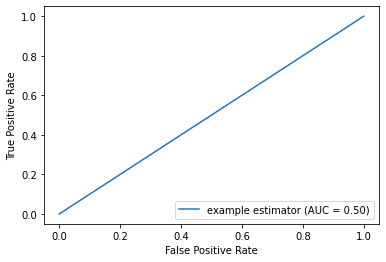

In [7]:
import matplotlib.pyplot as plt  
import numpy as np
from sklearn import metrics
import pickle

class roc_metrics:
  fpr_i = 0
  tpr_i = 0
  thresh_i = 0

y = lfw_pairs_test.target
fpr_nft, tpr_nft, thresholds_nft = metrics.roc_curve(y, preds)
# print(thresholds)
roc_auc = metrics.auc(fpr_nft, tpr_nft)
roc_cont = roc_metrics
roc_cont.fpr_i = fpr_nft
roc_cont.tpr_i = tpr_nft
roc_cont.thresh_i = thresholds_nft
display = metrics.RocCurveDisplay(fpr=fpr_nft, tpr=tpr_nft, roc_auc=roc_auc,estimator_name='example estimator')
display.plot()  
plt.show()

pickle.dump(roc_cont,open('VGG_con.pickle', 'wb'))

In [8]:
A = pickle.load(open('VGG_con.pickle', 'rb'))
A.thresh_i

array([2., 1.], dtype=float32)

### Fine-Tuning

In [9]:
#create verification model using siamese network;
img1 = keras.layers.Input(shape=IMG_SHAPE)
img2 =  keras.layers.Input( shape=IMG_SHAPE)
featureExtractor = tf_siamese_nn(IMG_SHAPE, fineTune=True)
featsA = featureExtractor(img1)
featsB = featureExtractor(img2)
# finally, construct the siamese network
distance = keras.layers.Lambda(euclidean_distance)([featsA, featsB])
outputs = keras.layers.Dense(1, activation="sigmoid")(distance)
model_ft = keras.Model(inputs=[img1, img2], outputs=outputs)
model_ft.summary()
model_ft.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

21
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_2 (Functional)            (None, 4096)         134260544   input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           model_2[0][0]           

In [10]:
#Training the model
train_pair_A = lfw_pairs_train.pairs[:,0].reshape(lfw_pairs_train.target.shape[0],224,224,3)
train_pair_B = lfw_pairs_train.pairs[:,1].reshape(lfw_pairs_train.target.shape[0],224,224,3)

history = model_ft.fit([train_pair_A, train_pair_B], lfw_pairs_train.target[:], validation_split=0.2 ,batch_size=4, epochs=50)
model_ft.save("fineTune_Model_10.h5")
print("Saved model to disk")

Epoch 1/50
440/440 [==============================] - 19s 39ms/step - loss: 3.1589 - accuracy: 0.4069 - val_loss: 0.8279 - val_accuracy: 0.0955
Epoch 2/50
440/440 [==============================] - 16s 37ms/step - loss: 0.8644 - accuracy: 0.4762 - val_loss: 0.5776 - val_accuracy: 0.7864
Epoch 3/50
440/440 [==============================] - 16s 37ms/step - loss: 0.6488 - accuracy: 0.6738 - val_loss: 0.7532 - val_accuracy: 0.2909
Epoch 4/50
440/440 [==============================] - 16s 37ms/step - loss: 0.5785 - accuracy: 0.7771 - val_loss: 0.5926 - val_accuracy: 0.6250
Epoch 5/50
440/440 [==============================] - 16s 37ms/step - loss: 0.5059 - accuracy: 0.8396 - val_loss: 0.6207 - val_accuracy: 0.5864
Epoch 6/50
440/440 [==============================] - 16s 37ms/step - loss: 0.4346 - accuracy: 0.8984 - val_loss: 0.6056 - val_accuracy: 0.6227
Epoch 7/50
440/440 [==============================] - 16s 37ms/step - loss: 0.3562 - accuracy: 0.9208 - val_loss: 0.5730 - val_accuracy:

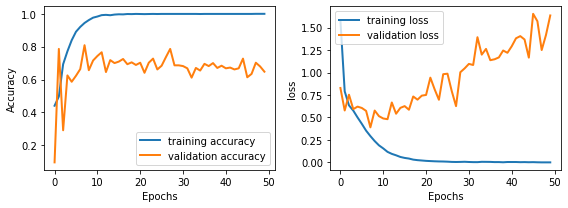

In [11]:
from sklearn.metrics import classification_report 
# print(classification_report(np.ravel(y), np.ravel(preds))) #np.ravel(preds)))

plt.figure(figsize=(8,3))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], linewidth=2)
plt.plot(history.history['val_accuracy'], linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['training accuracy', 'validation accuracy'], loc='best')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], linewidth=2)
plt.plot(history.history['val_loss'],linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend(['training loss', 'validation loss'], loc='best')
plt.tight_layout()

In [12]:
test_pairA = lfw_pairs_test.pairs[:,0].reshape(lfw_pairs_test.target.shape[0],224,224,3)
test_pairB = lfw_pairs_test.pairs[:,1].reshape(lfw_pairs_test.target.shape[0],224,224,3)

model_ft.evaluate([test_pairA , test_pairB], lfw_pairs_test.target, batch_size = 4)
preds = model_ft.predict([test_pairA , test_pairB])
print(preds[0:10])
print(lfw_pairs_test.target[0:10])

250/250 [==============================] - 7s 27ms/step - loss: 1.5104 - accuracy: 0.6880
[[0.9799508 ]
 [0.8609595 ]
 [0.26886287]
 [0.99101514]
 [0.55393636]
 [0.80444896]
 [0.9963575 ]
 [0.98579305]
 [0.349768  ]
 [0.56247413]]
[1 1 1 1 1 1 1 1 1 1]


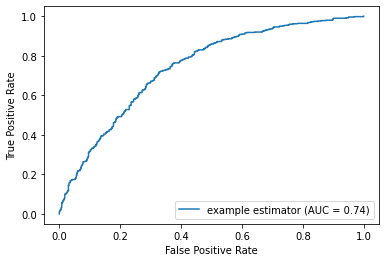

In [14]:
import matplotlib.pyplot as plt  
import numpy as np
from sklearn import metrics
import pickle

class roc_metrics:
  fpr_i = 0
  tpr_i = 0
  thresh_i = 0

y = lfw_pairs_test.target
fpr_ft, tpr_ft, thresholds_ft = metrics.roc_curve(y, preds)
roc_cont = roc_metrics
roc_cont.fpr_i = fpr_ft
roc_cont.tpr_i = tpr_ft
roc_cont.thresh_i = thresholds_nft
roc_auc = metrics.auc(fpr_ft, tpr_ft)
display = metrics.RocCurveDisplay(fpr=fpr_ft, tpr=tpr_ft, roc_auc=roc_auc, estimator_name='example estimator')
display.plot()  
plt.show()
pickle.dump(roc_cont,open('VGG_P1.pickle', 'wb'))